# Unit Reports

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
from pathlib import Path

import numpy as np
from scipy.stats import sem, ttest_rel
import matplotlib.pyplot as plt
from matplotlib import gridspec

from pynwb import NWBHDF5IO
from pingouin import convert_angles, circ_rayleigh

from spiketools.measures import compute_isis
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.plts.spikes import plot_isis
from spiketools.plts.space import plot_positions, plot_heatmap
from spiketools.plts.trials import plot_rasters
from spiketools.plts.data import plot_bar, plot_polar_hist, plot_text
from spiketools.plts.stats import plot_surrogates
from spiketools.stats.permutations import zscore_to_surrogates, compute_empirical_pvalue
from spiketools.spatial.occupancy import (compute_occupancy, compute_spatial_bin_edges,
                                          compute_spatial_bin_assignment)
from spiketools.spatial.information import compute_spatial_information_2d, _compute_spatial_information
from spiketools.utils.trials import epoch_spikes_by_event, epoch_spikes_by_range, epoch_data_by_range

In [3]:
import sys
sys.path.append('../code')
from utils import select_from_list
from analysis import calc_trial_frs, get_spike_positions, compute_bin_firing, get_spike_heading
from target import compute_serial_position_fr, compute_spatial_target_bins
from reports import *

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [6]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 3

In [7]:
# Set which example unit to extract
uind = 15

In [8]:
# Define bins to use
bins = [7, 21]
chest_bins = [5, 7]

# Define minimum occupancy
min_occ = 1

# Set the time range to analyze
trial_range = [-1, 1]

In [9]:
# Shuffle Settings
shuffle_approach = 'BINCIRC'
n_surrogates = 25

## Load Data

In [10]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [11]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

In [12]:
# Get the subject & session ID from file
subj_id = nwbfile.subject.subject_id
session_id = nwbfile.session_id

#### Trial Data

In [13]:
# Get start and stop time of trials
trial_starts = nwbfile.trials['start_time'].data[:]
trial_stops = nwbfile.trials['stop_time'].data[:]

In [14]:
# Get trial indices of interest
chest_trials = nwbfile.trials.chest_trials[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]

In [15]:
# Get masks for full and empty chest trials
full_mask = nwbfile.trials.full_chest.data[:]
empty_mask = np.invert(full_mask)

In [16]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

#### Position data

In [17]:
# Get area ranges, adding a buffer to the z-range (for tower transport)
area_range = [nwbfile.acquisition['boundaries']['x_range'].data[:], 
              nwbfile.acquisition['boundaries']['z_range'].data[:] + np.array([-10, 10])]

In [18]:
# Get the position data & speed data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [19]:
# Get position data for navigation segments
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

# Recombine position data across selected navigation trials
ptimes = np.hstack(ptimes_trials)
positions = np.hstack(positions_trials)
stimes = np.hstack(stimes_trials)
speed = np.hstack(speed_trials)

In [20]:
# # Extract head position data
# hd_times = nwbfile.acquisition['position']['head_direction'].timestamps[:]
# hd_degrees = nwbfile.acquisition['position']['head_direction'].data[:]

In [21]:
# Get the chest positions
chest_xs, chest_ys = nwbfile.acquisition['chest_positions']['chest_positions'].data[:].T

In [22]:
# Fix for extra chest position
if len(chest_xs) > len(chest_trials):
    chest_xs = chest_xs[:len(chest_trials)]
    chest_ys = chest_ys[:len(chest_trials)]

#### Get Spikes

In [23]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

### Precompute Some Things

In [24]:
# Get the spiking data for each trial
all_trials = epoch_spikes_by_range(spikes, trial_starts, trial_stops, reset=True)

In [25]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)

In [26]:
# Epoch around chest openings
all_chests = epoch_spikes_by_event(spikes, np.concatenate(chest_openings), trial_range)
empty_trials = select_from_list(all_chests, empty_mask)
full_trials = select_from_list(all_chests, full_mask)

In [27]:
# Compute firing rate around chest events
fr_pre_all, fr_post_all = calc_trial_frs(all_chests)
fr_pre_empt, fr_post_empt = calc_trial_frs(empty_trials)
fr_pre_full, fr_post_full = calc_trial_frs(full_trials)

In [28]:
# Compute bin edges
x_bin_edges, y_bin_edges = compute_spatial_bin_edges(positions, bins, area_range=area_range)

In [29]:
# Get position values for each spike
spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions)
spike_positions = np.array([spike_xs, spike_ys])

In [30]:
# Compute occupancy
occ = compute_occupancy(positions, ptimes, bins, 
                        speed, minimum=min_occ,
                        area_range=area_range, set_nan=True)

In [31]:
# Compute spatial bin assignments & binned firing
x_binl, y_binl = compute_spatial_bin_assignment(spike_positions, x_bin_edges, y_bin_edges)
bin_firing = compute_bin_firing(x_binl, y_binl, bins)

# Normalize bin firing by occupancy
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    norm_bin_firing = bin_firing / occ

In [32]:
# # Get head direction for each spike
# spike_hds = get_spike_heading(spikes, hd_times, hd_degrees)

In [33]:
# Compute edges for chest binning
ch_x_edges, ch_y_edges = compute_spatial_bin_edges(positions, chest_bins, area_range=area_range)

# Assign each chest to a bin
chest_pos = np.array([chest_xs, chest_ys])
ch_xbin, ch_ybin = compute_spatial_bin_assignment(chest_pos, ch_x_edges, ch_y_edges)

# Fix offset of chest binning
ch_xbin = ch_xbin - 1
ch_ybin = ch_ybin - 1

# Compute chest occupancy
chest_occupancy = compute_bin_firing(ch_xbin, ch_ybin, chest_bins)

In [34]:
# Collect firing per chest location across all trials
target_bins = compute_spatial_target_bins(spikes, nav_starts, chest_openings, chest_trials, 
                                          ptimes, positions, chest_bins, ch_xbin, ch_ybin)

In [35]:
# Compute firing rates per segment across all trials (serial position)
sp_all_frs = compute_serial_position_fr(spikes, nav_starts, chest_openings,
                                        chest_trials, ptimes, positions)

### Statistical Measures

In [36]:
# Compute t-test for chest related firing
fr_t_val_all, fr_p_val_all = ttest_rel(*calc_trial_frs(all_chests, average=False))
fr_t_val_full, fr_p_val_full = ttest_rel(*calc_trial_frs(full_trials, average=False))
fr_t_val_empt, fr_p_val_empt = ttest_rel(*calc_trial_frs(empty_trials, average=False))

In [37]:
# Compute the spatial information
place_info = compute_spatial_information_2d(spike_xs, spike_ys, [x_bin_edges, y_bin_edges], occ)

In [38]:
# Compute spatial information for the target firing
target_info = _compute_spatial_information(target_bins, chest_occupancy)

In [39]:
# # Compute measures for head direction
# hd_z_val, hd_p_val = circ_rayleigh(convert_angles(spike_hds))

### Surrogates

In [40]:
# Compute surrogate measures
place_surrs = np.zeros(n_surrogates)
target_surrs = np.zeros(n_surrogates)
sp_surrs = np.zeros(shape=[n_surrogates, 4])
#hd_surrs = np.zeros(n_surrogates)

for ind, stimes in enumerate(times_shuffle):    
    
    # PLACE
    s_spike_xs, s_spike_ys = get_spike_positions(stimes, ptimes, positions)
    place_surrs[ind] = compute_spatial_information_2d(s_spike_xs, s_spike_ys,
                                                      [x_bin_edges, y_bin_edges], occ)
    
    # TARGET
    s_target_bins = compute_spatial_target_bins(stimes, nav_starts,
                                                chest_openings, chest_trials, 
                                                ptimes, positions,
                                                chest_bins, ch_xbin, ch_ybin)         
    target_surrs[ind] = _compute_spatial_information(s_target_bins, chest_occupancy)
    
    # SERIAL POSITION
    sp_surrs_frs = compute_serial_position_fr(\
        stimes, nav_starts, chest_openings, chest_trials, ptimes, positions) 
    sp_surrs[ind] = np.mean(sp_surrs_frs, 0)
    
#     # HEAD DIRECTION
#     s_spike_hds = get_spike_heading(stimes, hd_times, hd_degrees)
#     hd_surrs[ind] = circ_rayleigh(convert_angles(s_spike_hds))[0]

In [41]:
# Place surrogate measures
place_surr_p_val = compute_empirical_pvalue(place_info, place_surrs)
place_z_score = zscore_to_surrogates(place_info, place_surrs)

# Target surrogate measures
target_surr_p_val = compute_empirical_pvalue(target_info, target_surrs)
target_z_score = zscore_to_surrogates(target_info, target_surrs)

# Serial position surrogate measures
sp_surr_p_vals = [compute_empirical_pvalue(sp_all_frs.mean(0)[ind], sp_surrs[:, ind]) for ind in range(4)]
sp_z_scores = [zscore_to_surrogates(sp_all_frs.mean(0)[ind], sp_surrs[:, ind]) for ind in range(4)]

# # Head direction surrogate measures
# hd_surr_p_val = compute_empirical_pvalue(hd_z_val, hd_surrs)
# hd_z_score = zscore_to_surrogates(hd_z_val, hd_surrs)

## Create Report

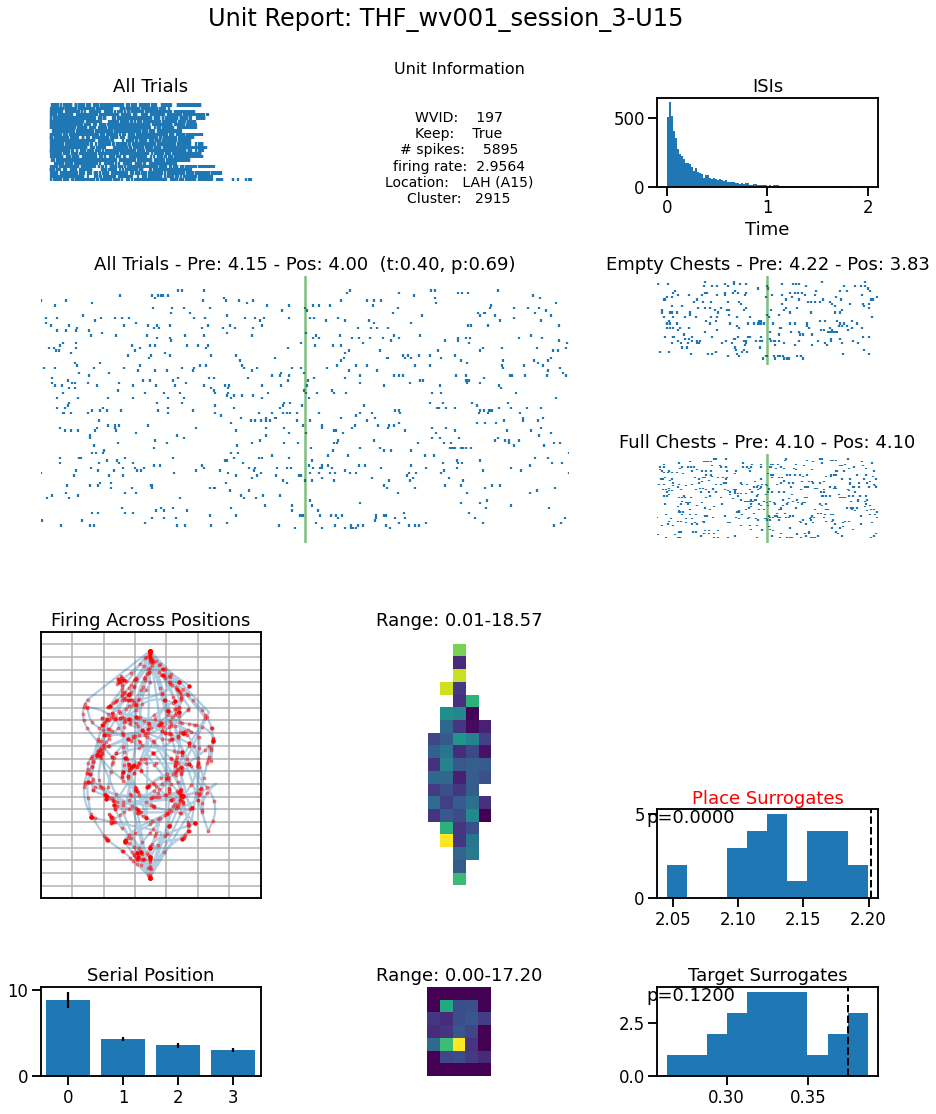

In [42]:
# Initialize figure
_ = plt.figure(figsize=(15, 18))
grid = gridspec.GridSpec(6, 3, wspace=0.4, hspace=1.)

# 00: plot rasters across all trials
ax00 = plt.subplot(grid[0, 0])
plot_rasters(all_trials, ax=ax00, title='All Trials')

# 01: unit information
ax01 = plt.subplot(grid[0, 1])
plot_text(create_unit_str(create_unit_info(nwbfile.units[uind])), ax=ax01)
ax01.set_title("Unit Information", fontdict={'fontsize' : 16}, y=1.2)

# 02: inter-spike intervals
ax02 = plt.subplot(grid[0, 2])
isis = compute_isis(spikes)
plot_isis(isis, bins=100, range=(0, 2), ax=ax02)

# 10: chest related firing
ax10 = plt.subplot(grid[1:3, 0:2])
plot_rasters(all_chests, xlim=trial_range, vline=0, figsize=(10, 7), ax=ax10)
title_str = 'All Trials - Pre: {:1.2f} - Pos: {:1.2f}  (t:{:1.2f}, p:{:1.2f})'
ax10.set_title(title_str.format(fr_pre_all, fr_post_all, fr_t_val_all, fr_p_val_all),
               color='red' if fr_p_val_all < 0.05 else 'black')

# 12&22: Compare Empty & Full chest trials
title_str = '{} Chests - Pre: {:1.2f} - Pos: {:1.2f}'
# Empty chest trials
ax12 = plt.subplot(grid[1, 2])
plot_rasters(empty_trials, xlim=trial_range, vline=0, ax=ax12)
ax12.set_title(title_str.format('Empty', fr_pre_empt, fr_post_empt),
               color='red' if fr_p_val_empt < 0.05 else 'black')
# Full chest trials
ax22 = plt.subplot(grid[2, 2])
plot_rasters(full_trials, xlim=trial_range, vline=0, ax=ax22)
ax22.set_title(title_str.format('Full', fr_pre_full, fr_post_full),
               color='red' if fr_p_val_full < 0.05 else 'black')

# ax30: positional firing
ax30 = plt.subplot(grid[3:5, 0])
plot_positions(positions, spike_positions,
               x_bins=x_bin_edges, y_bins=y_bin_edges, ax=ax30,
               title='Firing Across Positions')

# ax31: positional heatmap
ax31 = plt.subplot(grid[3:5, 1])
plot_heatmap(norm_bin_firing, transpose=True, ax=ax31, 
             title='Range: {:1.2f}-{:1.2f}'.format(np.nanmin(norm_bin_firing),
                                                   np.nanmax(norm_bin_firing)))

# # ax32: head direction of spike firing
# ax32 = plt.subplot(grid[3, 2], polar=True)
# plot_polar_hist(spike_hds, ax=ax32)
# ax32.set(xticklabels=[], yticklabels=[])
# tcol32 = 'red' if hd_surr_p_val < 0.05 else 'black'
# ax32.set_title('Head Direction', color=tcol32)

# ax42: place surrogates
ax42 = plt.subplot(grid[4, 2])
plot_surrogates(place_surrs, place_info, place_surr_p_val, ax=ax42)
ax42.set_title('Place Surrogates',
               color='red' if place_surr_p_val < 0.05 else 'black')

# ax50: serial position - firing rates across trial segments
ax50 = plt.subplot(grid[5, 0])
plot_bar(sp_all_frs.mean(0), [0, 1, 2, 3], yerr=sem(sp_all_frs, 0), ax=ax50, 
         title='Serial Position')
for ind, p_val in enumerate(sp_surr_p_vals):
    if p_val < 0.05:
        ax50.text(ind, ax50.get_ylim()[1]-0.15*ax50.get_ylim()[1],
                '*', c='red', fontdict={'fontsize' : 25}, ha='center')

# ax51: spatial target firing
ax51 = plt.subplot(grid[5, 1])
plot_heatmap(target_bins, transpose=True, ax=ax51,
             title='Range: {:1.2f}-{:1.2f}'.format(np.nanmin(target_bins), np.nanmax(target_bins)))

# ax52: target surrogates
ax52 = plt.subplot(grid[5, 2])
plot_surrogates(target_surrs, target_info, target_surr_p_val, ax=ax52)
ax52.set_title('Target Surrogates',
               color='red' if target_surr_p_val < 0.05 else 'black')

# Add super title to the report
suptitle = 'Unit Report: {}-U{}'.format(session_id, uind)
plt.suptitle(suptitle, fontsize=24, y=0.95);